In [1]:
import gc
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from ipywidgets import interact, interact_manual
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix
from scipy.stats import f_oneway, kruskal, zscore
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline
sns.set(style='darkgrid')

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
def get_features(features_path):
    """
    Fetch features for the HAR dataset
    
    Args:
        features_path (str): Path to the feature names
    
    Returns:
        features (list): List containing all feature names
    """
    with open(features_path, 'r') as file:
        features = file.readlines()
    features = [feature.strip()  for feature in features]
    return features

def get_labels_dictionary(labels_path):
    """
    Fetch labels for the HAR dataset
    
    Args:
        labels_path (str): Path to the file containing label dict
    
    Returns: (dict) Label dictionary containing label-code and label pairs
        
    """
    with open(labels_path, 'r') as f:
        return {int(line.split()[0]):line.split()[1] for line in f}

def get_data(id_path, x_path, y_path, features_path, labels_path):
    """
    Combine x, y, features, and IDs for the HAR dataset
    
    Args:
        id_path (str): Path to unique patient identifiers
        x_path (str): Path to x (data without labels and feature names)
        y_path (str): Path to y (label codes)
        features_path(str): Path to feature names
        labels_path (str): Path to file containing label dict
    
    Returns:
        df (pd.DataFrame): dataframe containing the fetched HAR data
        """
    id_df = pd.read_csv(id_path, header=None, names=['id'])
    features = get_features(features_path)
    x = pd.read_csv(x_path, header=None, names=features, sep=' ')
    y = pd.read_csv(y_path, header=None, names=['activity'])
    y.replace(to_replace=get_labels_dictionary(labels_path), inplace=True)
    df = pd.concat([id_df, x, y], axis=1)
    return df

data_dir = os.path.join(os.getcwd(), 'data')

train_dir = os.path.join(data_dir, 'Train')
train_x_path = os.path.join(train_dir, 'X_train.txt')
train_y_path = os.path.join(train_dir, 'y_train.txt')
train_id_path = os.path.join(train_dir, 'subject_id_train.txt')

test_dir = os.path.join(data_dir, 'Test')
test_x_path = os.path.join(test_dir, 'X_test.txt')
test_y_path = os.path.join(test_dir, 'y_test.txt')
test_id_path = os.path.join(test_dir, 'subject_id_test.txt')

features_path = os.path.join(data_dir, 'features.txt')
labels_path = os.path.join(data_dir, 'activity_labels.txt')

train_df = get_data(train_id_path, train_x_path, train_y_path, features_path, labels_path)
test_df = get_data(test_id_path, test_x_path, test_y_path, features_path, labels_path)

In [5]:
train_df.describe()

,id,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,tBodyAcc-Max-2,tBodyAcc-Max-3,tBodyAcc-Min-1,tBodyAcc-Min-2,tBodyAcc-Min-3,tBodyAcc-SMA-1,tBodyAcc-Energy-1,tBodyAcc-Energy-2,tBodyAcc-Energy-3,tBodyAcc-IQR-1,tBodyAcc-IQR-2,tBodyAcc-IQR-3,tBodyAcc-ropy-1,tBodyAcc-ropy-2,tBodyAcc-ropy-3,tBodyAcc-ARCoeff-1,tBodyAcc-ARCoeff-2,tBodyAcc-ARCoeff-3,tBodyAcc-ARCoeff-4,tBodyAcc-ARCoeff-5,tBodyAcc-ARCoeff-6,tBodyAcc-ARCoeff-7,tBodyAcc-ARCoeff-8,tBodyAcc-ARCoeff-9,tBodyAcc-ARCoeff-10,tBodyAcc-ARCoeff-11,tBodyAcc-ARCoeff-12,tBodyAcc-Correlation-1,tBodyAcc-Correlation-2,tBodyAcc-Correlation-3,tGravityAcc-Mean-1,tGravityAcc-Mean-2,tGravityAcc-Mean-3,tGravityAcc-STD-1,tGravityAcc-STD-2,tGravityAcc-STD-3,tGravityAcc-Mad-1,tGravityAcc-Mad-2,tGravityAcc-Mad-3,tGravityAcc-Max-1,tGravityAcc-Max-2,tGravityAcc-Max-3,tGravityAcc-Min-1,tGravityAcc-Min-2,tGravityAcc-Min-3,tGravityAcc-SMA-1,tGravityAcc-Energy-1,tGravityAcc-Energy-2,tGravityAcc-Energy-3,tGravityAcc-IQR-1,tGravityAcc-IQR-2,tGravityAcc-IQR-3,tGravityAcc-ropy-1,tGravityAcc-ropy-2,tGravityAcc-ropy-3,tGravityAcc-ARCoeff-1,tGravityAcc-ARCoeff-2,tGravityAcc-ARCoeff-3,tGravityAcc-ARCoeff-4,tGravityAcc-ARCoeff-5,tGravityAcc-ARCoeff-6,tGravityAcc-ARCoeff-7,tGravityAcc-ARCoeff-8,tGravityAcc-ARCoeff-9,tGravityAcc-ARCoeff-10,tGravityAcc-ARCoeff-11,tGravityAcc-ARCoeff-12,tGravityAcc-Correlation-1,tGravityAcc-Correlation-2,tGravityAcc-Correlation-3,tBodyAccJerk-Mean-1,tBodyAccJerk-Mean-2,tBodyAccJerk-Mean-3,tBodyAccJerk-STD-1,tBodyAccJerk-STD-2,tBodyAccJerk-STD-3,tBodyAccJerk-Mad-1,tBodyAccJerk-Mad-2,tBodyAccJerk-Mad-3,tBodyAccJerk-Max-1,tBodyAccJerk-Max-2,tBodyAccJerk-Max-3,tBodyAccJerk-Min-1,tBodyAccJerk-Min-2,tBodyAccJerk-Min-3,tBodyAccJerk-SMA-1,tBodyAccJerk-Energy-1,tBodyAccJerk-Energy-2,tBodyAccJerk-Energy-3,tBodyAccJerk-IQR-1,tBodyAccJerk-IQR-2,tBodyAccJerk-IQR-3,tBodyAccJerk-ropy-1,tBodyAccJerk-ropy-2,tBodyAccJerk-ropy-3,tBodyAccJerk-ARCoeff-1,tBodyAccJerk-ARCoeff-2,tBodyAccJerk-ARCoeff-3,tBodyAccJerk-ARCoeff-4,tBodyAccJerk-ARCoeff-5,tBodyAccJerk-ARCoeff-6,tBodyAccJerk-ARCoeff-7,tBodyAccJerk-ARCoeff-8,tBodyAccJerk-ARCoeff-9,tBodyAccJerk-ARCoeff-10,tBodyAccJerk-ARCoeff-11,tBodyAccJerk-ARCoeff-12,tBodyAccJerk-Correlation-1,tBodyAccJerk-Correlation-2,tBodyAccJerk-Correlation-3,tBodyGyro-Mean-1,tBodyGyro-Mean-2,tBodyGyro-Mean-3,tBodyGyro-STD-1,tBodyGyro-STD-2,tBodyGyro-STD-3,tBodyGyro-Mad-1,tBodyGyro-Mad-2,tBodyGyro-Mad-3,tBodyGyro-Max-1,tBodyGyro-Max-2,tBodyGyro-Max-3,tBodyGyro-Min-1,tBodyGyro-Min-2,tBodyGyro-Min-3,tBodyGyro-SMA-1,tBodyGyro-Energy-1,tBodyGyro-Energy-2,tBodyGyro-Energy-3,tBodyGyro-IQR-1,tBodyGyro-IQR-2,tBodyGyro-IQR-3,tBodyGyro-ropy-1,tBodyGyro-ropy-2,tBodyGyro-ropy-3,tBodyGyro-ARCoeff-1,tBodyGyro-ARCoeff-2,tBodyGyro-ARCoeff-3,tBodyGyro-ARCoeff-4,tBodyGyro-ARCoeff-5,tBodyGyro-ARCoeff-6,tBodyGyro-ARCoeff-7,tBodyGyro-ARCoeff-8,tBodyGyro-ARCoeff-9,tBodyGyro-ARCoeff-10,tBodyGyro-ARCoeff-11,tBodyGyro-ARCoeff-12,tBodyGyro-Correlation-1,tBodyGyro-Correlation-2,tBodyGyro-Correlation-3,tBodyGyroJerk-Mean-1,tBodyGyroJerk-Mean-2,tBodyGyroJerk-Mean-3,tBodyGyroJerk-STD-1,tBodyGyroJerk-STD-2,tBodyGyroJerk-STD-3,tBodyGyroJerk-Mad-1,tBodyGyroJerk-Mad-2,tBodyGyroJerk-Mad-3,tBodyGyroJerk-Max-1,tBodyGyroJerk-Max-2,tBodyGyroJerk-Max-3,tBodyGyroJerk-Min-1,tBodyGyroJerk-Min-2,tBodyGyroJerk-Min-3,tBodyGyroJerk-SMA-1,tBodyGyroJerk-Energy-1,tBodyGyroJerk-Energy-2,tBodyGyroJerk-Energy-3,tBodyGyroJerk-IQR-1,tBodyGyroJerk-IQR-2,tBodyGyroJerk-IQR-3,tBodyGyroJerk-ropy-1,tBodyGyroJerk-ropy-2,tBodyGyroJerk-ropy-3,tBodyGyroJerk-ARCoeff-1,tBodyGyroJerk-ARCoeff-2,tBodyGyroJerk-ARCoeff-3,tBodyGyroJerk-ARCoeff-4,tBodyGyroJerk-ARCoeff-5,tBodyGyroJerk-ARCoeff-6,tBodyGyroJerk-ARCoeff-7,tBodyGyroJerk-ARCoeff-8,tBodyGyroJerk-ARCoeff-9,tBodyGyroJerk-ARCoeff-10,tBodyGyroJerk-ARCoeff-11,tBodyGyroJerk-ARCoeff-12,tBodyGyroJerk-Correlation-1,tBodyGyroJerk-Correlation-2,tBodyGyroJerk-Correlation-3,tBodyAccMag-Mean-1,tBodyAc

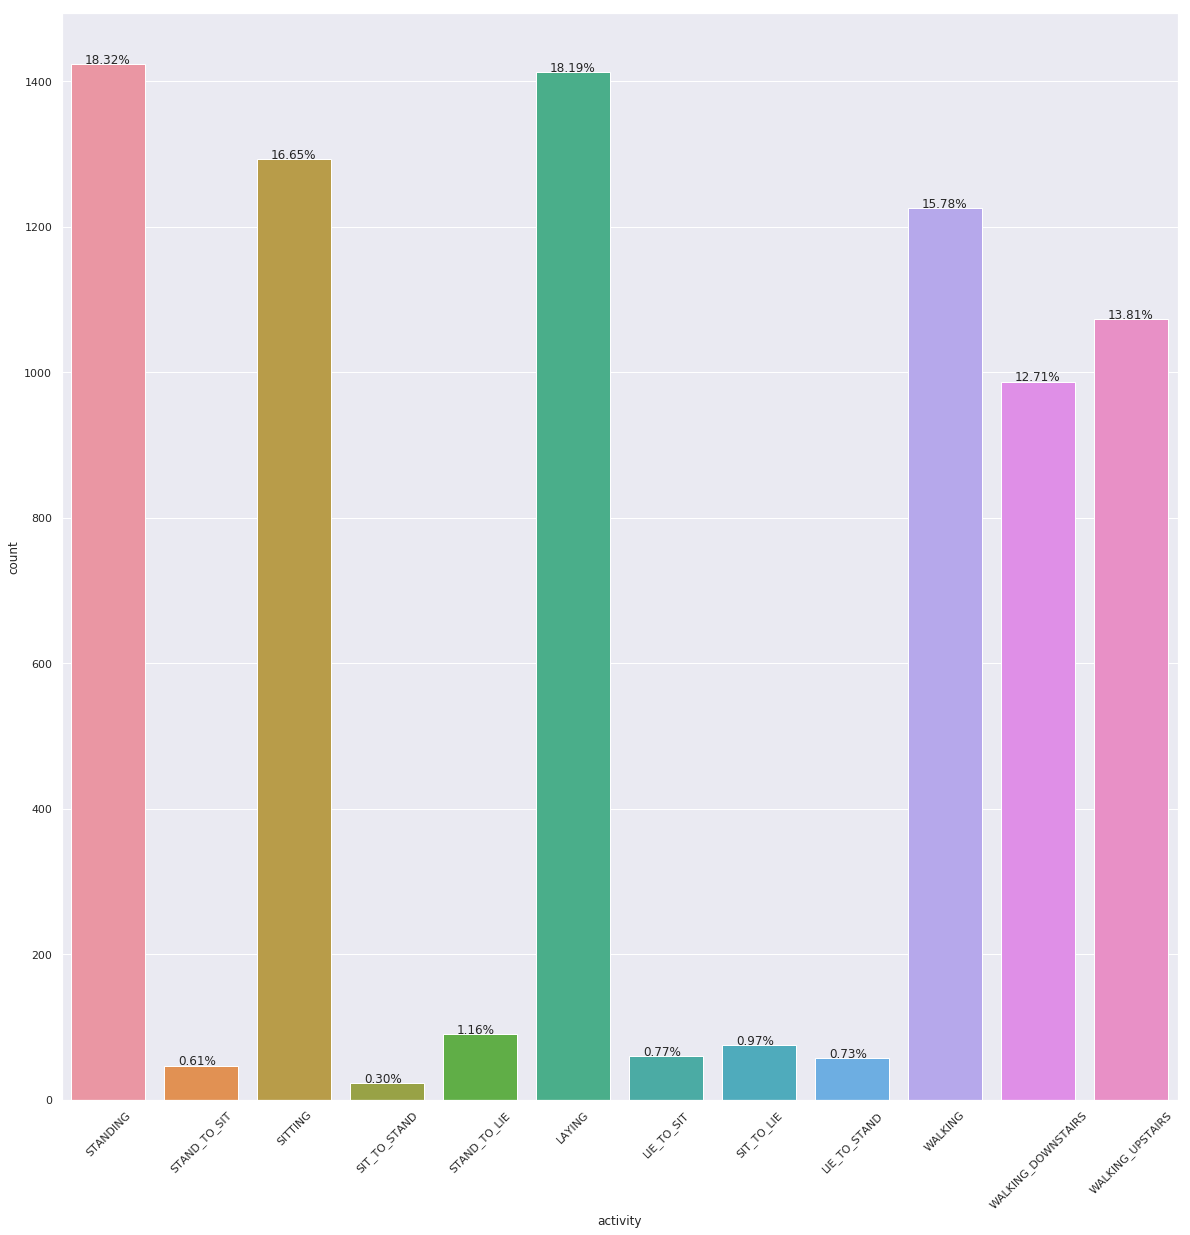

In [6]:
plt.figure(figsize=(20, 20))
ax = sns.countplot(x='activity', data=train_df)
_= plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100 / train_df.shape[0]), (p.get_x()+0.15, p.get_height()+1))

There exists a class imbalance in our dataset, with `SIT_TO_STAND` as a label for only 0.3% of the data points, while `STANDING` is the label for 18.32% of the data points.

In [23]:
features = get_features(features_path)

In [24]:
@interact
def display_distribution(column=features):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    sns.violinplot(train_df[column], ax=axes[0])
    sns.violinplot(x='activity', y=column, data=train_df, ax=axes[1])
    _ = plt.xticks(rotation=45)

A Jupyter Widget

#### Estimating association between the features and the labels

We will estimate every feature's association with that of the target variable, `activity`, to see which features could contribute significantly to HAR. 

For every feature, we compute its variance across the training dataset. Next, we group the entries in the dataset based on the activity, and compute each group's variance for the aforementioned feature. If the variance after the grouping falls down significantly, then it means that `activity` can explain most of the variance observed in the said feature. We divide each group's variance by the variance of all the groups combined, and add all of these ratios. We then go on to divide this value by the total number of groups, 12 in this case. If the variance observed after grouping does not change, then this value should be close to 1. Lower the value, the better the variance of the feature can be explained by `activity`.

In [39]:
variance_ratio = lambda feature: train_df[[feature, 'activity']]\
.groupby(['activity']).var()\
.apply(lambda x: x / train_df[feature].var()).sum().values[0] / 12

In [40]:
variance_ratios_df = pd.DataFrame([[feature, variance_ratio(feature)] for feature in features]
                                  , columns=['feature', 'variance_ratio'])

In [41]:
variance_ratios_df.sort_values(by='variance_ratio')

,feature,variance_ratio
234,tBodyAccJerkMag-ropy-1,0.055648
102,tBodyAccJerk-ropy-1,0.060068
287,fBodyAcc-ropy-1,0.063420
366,fBodyAccJerk-ropy-1,0.068516
103,tBodyAccJerk-ropy-2,0.069076
367,fBodyAccJerk-ropy-2,0.069793
288,fBodyAcc-ropy-2,0.074055
510,fBodyAccMag-ropy-1,0.075636
523,fBodyAccJerkMag-ropy-1,0.081781
260,tBodyGyroJerkMag-ropy-1,0.083280


In [61]:
variance_ratios_df[variance_ratios_df.variance_ratio <= 1].shape[0]

473

For 473 features, the average variance across groups remains the same as the variance for all the groups combined, or lesser.

To see whether there is an association between the features and the target variable, `activity`, we try a different approach. We perform a Kruskal-Wallis H Test, where we hypothesize that the medians of the groups created by `activity`, for a particular feature, are the same. We aim to calculate p-values for the corresponding H-statistic, which would allow us to reject this null hypothesis (p < 0.05) and establish an association. 

In [11]:
hstatistics = []
pvalues = []
for feature in tqdm(features):
    samples = []
    for i, activity in enumerate(train_df.activity.unique().tolist()):
        samples.append(train_df[train_df.activity == activity][feature].tolist())
    result = kruskal(*samples)
    hstatistics.append(result[0])
    pvalues.append(result[1])

A Jupyter Widget

In [12]:
kw_df = pd.DataFrame({'feature': features, 'hstatistic': hstatistics, 'pvalue': pvalues})

In [13]:
kw_df.sort_values(by=['pvalue'])

,feature,hstatistic,pvalue
280,fBodyAcc-SMA-1,6086.542476,0.000000e+00
368,fBodyAccJerk-ropy-3,6320.030970,0.000000e+00
367,fBodyAccJerk-ropy-2,6396.819944,0.000000e+00
366,fBodyAccJerk-ropy-1,6584.044417,0.000000e+00
365,fBodyAccJerk-IQR-3,6053.002572,0.000000e+00
364,fBodyAccJerk-IQR-2,6055.195793,0.000000e+00
363,fBodyAccJerk-IQR-1,6160.513299,0.000000e+00
362,fBodyAccJerk-Energy-3,6070.200977,0.000000e+00
361,fBodyAccJerk-Energy-2,6130.474091,0.000000e+00
360,fBodyAccJerk-Energy-1,6224.396555,0.000000e+00


For some reason, the Kruskal-Wallis H-Test does not work that well for our dataset, since it returns the same H-statistic and p-value = `0.0` for all of the features. That does not seem plausible. The reason we choose Kruskal Wallis over One-way ANOVA, is because the latter makes assumption about the samples. Kruskal would be ideal in our case, but does not provide any conclusive results. 

Next step would be to check the correlation between the features themselves.

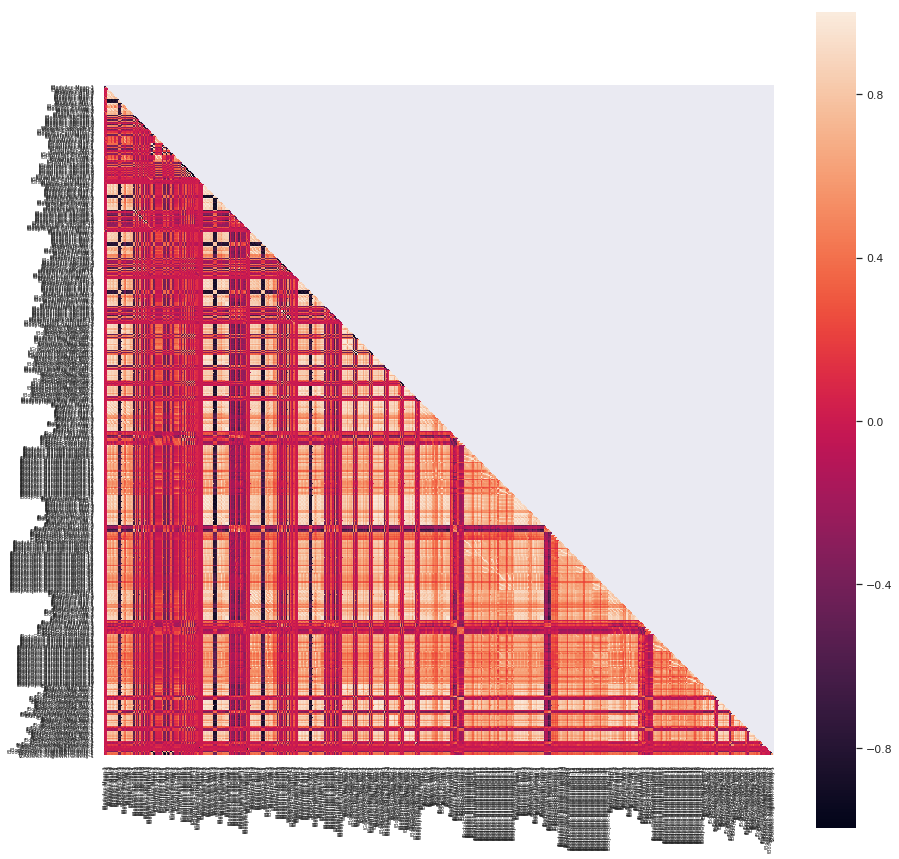

In [20]:
corr = train_df.drop(['id', 'activity'], axis=1).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=mask, square=True)
_ = plt.xticks(list(range(1, len(corr.columns) + 1))
           , corr.columns.tolist()
           , fontsize=5
           , rotation=90)
_ = plt.yticks(list(range(1, len(corr.columns) + 1))
           , corr.columns.tolist()
           , fontsize=5)

The above correlation heatmap shows that we have features that may be highly correlated with some or most of the other features. We may want to reduce the number of dimensions in this case, since correlation indicates redundant information. Our first choice of algorithm for dimensionality reduction is PCA, which means we will have to remove the outliers in the dataset. This is because PCA is does not do well if outliers exist in the dataset. 

We use the z-score method of outlier detection, i.e. we consider a data point to be an outlier if all of the dimensions is `< mean + 3 * std` or `> mean + 3 * std`. This is a pretty relaxed constraint. 

In [25]:
train_df['split'] = pd.Series(['train'] * train_df.shape[0])
test_df['split'] = pd.Series(['test'] * test_df.shape[0])
data_df = pd.concat([train_df, test_df])

In [26]:
data_df, non_numeric_data_df = data_df.drop(['id', 'split', 'activity']
                                       , axis=1),\
                               data_df[['id', 'split', 'activity']]

In [27]:
norm_data_df = MinMaxScaler().fit_transform(data_df.values)

In [28]:
pca = PCA(n_components=norm_data_df.shape[1])
pca_data_df = pca.fit_transform(norm_data_df)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

Text(0, 0.5, '% Explained Variance Ratio')

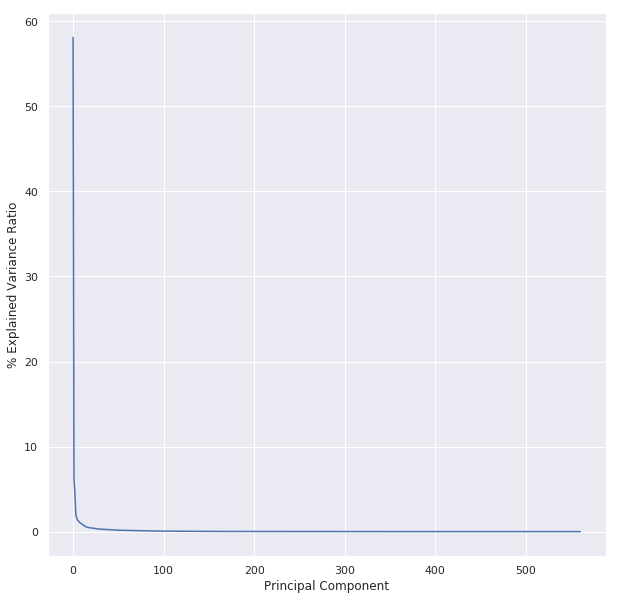

In [34]:
plt.figure(figsize=(10, 10))
sns.lineplot(np.arange(pca.explained_variance_ratio_.shape[0])
             , pca.explained_variance_ratio_ * 100)
plt.xlabel('Principal Component')
plt.ylabel('% Explained Variance Ratio')

In [15]:
(explained_variance <= 0.8).sum()

12

In [16]:
(explained_variance <= 0.9).sum()

38

80% of the variance in the dataset can be explained by 12 principal components, 90% by 38 principal components. That is a significant reduction in dimensions as compared to the original 561 feature dimensions.

In [17]:
pca_data_df = pd.DataFrame(pca_data_df)
pca_data_df = pd.merge(pca_data_df
                       , non_numeric_data_df
                       , left_index=True
                       , right_index=True)

In [18]:
pca_train_df = pca_data_df[pca_data_df.split == 'train']\
                          .drop(['split'], axis=1)
pca_test_df = pca_data_df[pca_data_df.split == 'test']\
                         .drop(['split'], axis=1)

In [36]:
def plot_3d(df, target, columns):
    """
    Plot 3D scatterplots for dataframe containing a target variable,
    where the axes can be any specified column of the dataframe.
    The scatterplot will be color coded based on the target variable
    provided.
    
    Args:
        df (pd.DataFrame): Dataframe consisting a target 
                           categorical column
        target (str): Target categorical variable column
        columns (dict): Dictionary specifying column keys for plotting,
                        and corresponding axis label (key: label)
    
    Returns: None
    """
    unique_labels = df[target].unique()
    column_keys = list(columns.keys())
    column_values = list(columns.values())
    colors = cm.rainbow(np.linspace(0
                                    , 1
                                    , len(unique_labels)))
    label_colors = {}
    for i, label in enumerate(unique_labels):
        label_colors[label] = colors[i]
    df['colors'] = df[target].apply(lambda x: label_colors[x])
    figure = plt.figure(figsize=(10, 10))
    ax = Axes3D(figure)
    _ = ax.scatter(df[column_keys[0]]
                   , df[column_keys[1]]
                   , df[column_keys[2]]
                   , c=df['colors'])
    _ = ax.set_xlabel(column_values[0])
    _ = ax.set_ylabel(column_values[1])
    _ = ax.set_zlabel(column_values[2])

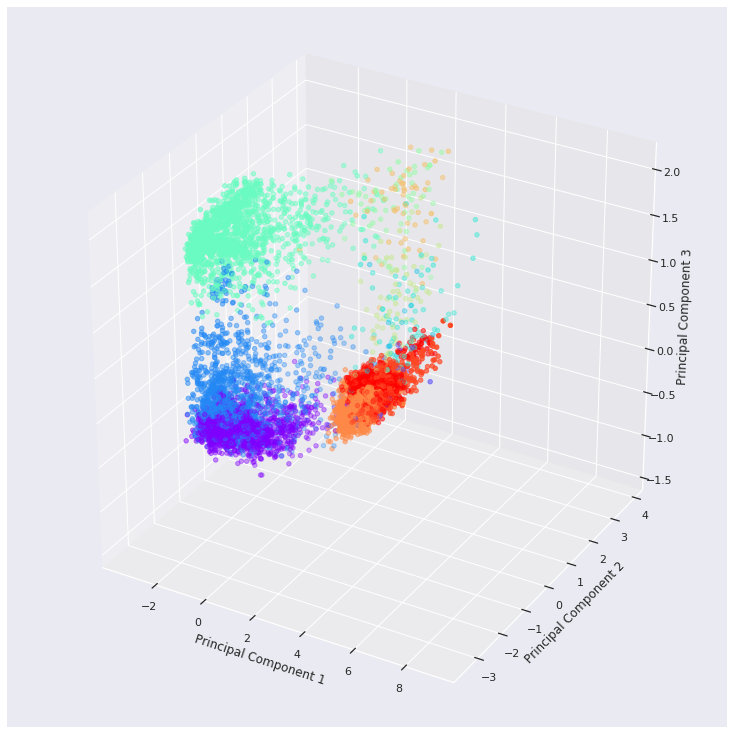

In [20]:
columns = {0: 'Principal Component 1'
          , 1: 'Principal Component 2'
          , 2: 'Principal Component 3'}
plot_3d(pca_train_df, 'activity', columns)

Above is a scatterplot of the data, if we only consider 3 principal components (~69% of explained variance). Each label has a unique color, and as you can see, the data points having the same label seem to be nearby. There also exist some outliers, which passed through our (rather relaxed) outlier detection. Also, this is after performing PCA, which means that we may have to try a more robust (to noise or outliers) dimensionality reduction technique.

We can use outlier detection algorithms like - DBSCAN (Clustering algorithm, which also detects outliers) or Isolation Forest. Both of these algorithms can be used for high-dimensional data. For DBSCAN, we will have to use manhattan distance, instead of euclidean, since euclidean does not work well with high-dimensional data. We will also have to decide an epsilon for DBSCAN, so as to distinguish outliers from inliers.

In [30]:
d_matrix = distance_matrix(norm_data_df, norm_data_df, p=1)
d_matrix [d_matrix == 0] = np.inf
d_matrix = d_matrix.min(axis=1)

/home/mihin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


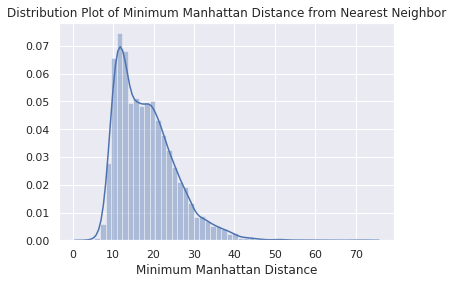

In [44]:
_ = sns.distplot(d_matrix)
_ = plt.title('Distribution Plot of Minimum Manhattan Distance from Nearest Neighbor')
_ = plt.xlabel('Minimum Manhattan Distance')

Above is the distribution of the minimum manhattan distance of a data point from its nearest neighbor. If we want to get rid of outliers using DBSCAN, we have to choose an appropriate epsilon based on the above distribution. Since we want to avoid false positives, we want to keep this distance really high (=40). 

In [21]:
dbscan = DBSCAN(eps=40, metric='manhattan')
outliers = dbscan.fit_predict(norm_data_df)
print("Number of outliers = {}".format((outliers == -1).sum()))

Number of outliers = 168


Using DBSCAN with manhattan distance metric, and an epsilon of 40, there seem to be 168 outliers. Next steps, merge this with the original dataset (non-numeric features as well) and see which class do most of the outliers come from. 

In [22]:
o_data_df = pd.DataFrame(outliers, columns=['outlier'])
norm_data_df = pd.DataFrame(norm_data_df)
o_data_df = o_data_df.merge(norm_data_df
                            , left_index=True
                            , right_index=True)
o_data_df = o_data_df.merge(non_numeric_data_df
                            , left_index=True
                            , right_index=True)

In [23]:
print("Number of unique activities in inliers = {}"
      .format(o_data_df[o_data_df.outlier != -1].activity.nunique()))

Number of unique activities in inliers = 12


In [24]:
print("Number of unique activities in outliers = {}"
      .format(o_data_df[o_data_df.outlier == -1].activity.nunique()))

Number of unique activities in outliers = 12


We had outliers for every activity, and even after removing them, we still have instances for all 12 activities. We need to see the percentage of data points affected for every activity.

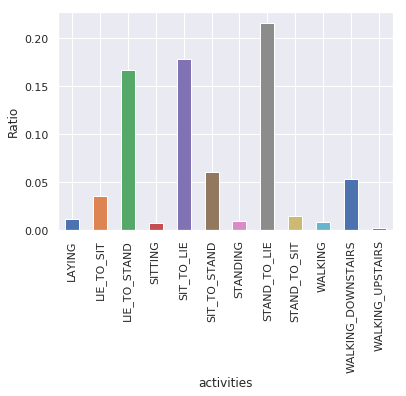

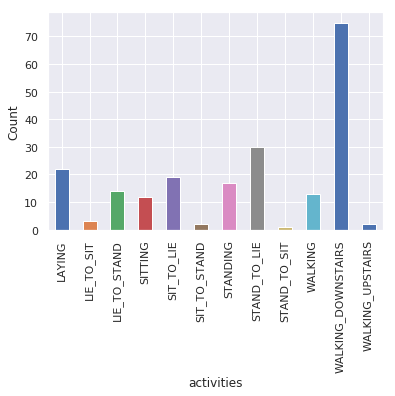

In [25]:
outlier_activity_counts = o_data_df[o_data_df.outlier == -1]\
                                   .groupby('activity')['id'].count()

inlier_activity_counts = o_data_df[o_data_df.outlier != -1]\
                                  .groupby('activity')['id'].count()

outlier_activity_ratios = outlier_activity_counts /\
                          (outlier_activity_counts 
                           + inlier_activity_counts)

_ = pd.DataFrame({'ratio': outlier_activity_ratios
                  , 'activities': outlier_activity_ratios.index})\
                .plot.bar(x='activities', y='ratio', legend=False)
_ = plt.ylabel('Ratio')

_ = pd.DataFrame({'count': outlier_activity_counts
                 , 'activities': outlier_activity_counts.index})\
                .plot.bar(x='activities', y='count', legend=False)
_ = plt.ylabel('Count')

According to the above plot, ratio of outliers to total data points for transitional activities such as `LIE_TO_STAND`, `SIT_TO_LIE` is really high in comparison to other static/dynamic activities (even though the number of outliers itself is low). This may not necessarily mean that these particular activities have more outliers. For the purpose of not removing information from an already class-imbalanced dataset, we can consider all non-transitional activity data points as inliers. 

In [26]:
print("Shape of o_data_df before removing outliers: {}"
      .format(o_data_df.shape))

Shape of o_data_df before removing outliers: (10929, 565)


In [27]:
o_data_df = o_data_df[(o_data_df.outlier != -1) 
          | (o_data_df.activity == 'STAND_TO_SIT')
          | (o_data_df.activity == 'STAND_TO_LIE')
          | (o_data_df.activity == 'SIT_TO_STAND')
          | (o_data_df.activity == 'SIT_TO_LIE')
          | (o_data_df.activity == 'LIE_TO_STAND')
          | (o_data_df.activity == 'LIE_TO_SIT')]

In [28]:
print("Shape of o_data_df after removing outliers: {}"
      .format(o_data_df.shape))

Shape of o_data_df after removing outliers: (10788, 565)


In [29]:
o_index = o_data_df.index
o_data_df, o_non_numeric_data_df = o_data_df.drop(['id'
                                                   , 'split'
                                                   , 'activity'
                                                   , 'outlier']
                                       , axis=1),\
                                   o_data_df[['id'
                                              , 'split'
                                              , 'activity']]

In [30]:
o_pca = PCA(n_components=o_data_df.shape[1])
o_pca_data_df = o_pca.fit_transform(o_data_df)

o_explained_variance = np.cumsum(o_pca.explained_variance_ratio_)

In [31]:
(o_explained_variance <= 0.8).sum()

11

In [32]:
(o_explained_variance <= 0.9).sum()

37

In [33]:
o_pca_data_df = pd.DataFrame(o_pca_data_df, index=o_index)
o_pca_data_df = pd.merge(o_pca_data_df
                       , o_non_numeric_data_df
                       , left_index=True
                       , right_index=True)

In [34]:
o_pca_train_df = o_pca_data_df[o_pca_data_df.split == 'train']\
                          .drop(['split'], axis=1)
o_pca_test_df = o_pca_data_df[o_pca_data_df.split == 'test']\
                         .drop(['split'], axis=1)

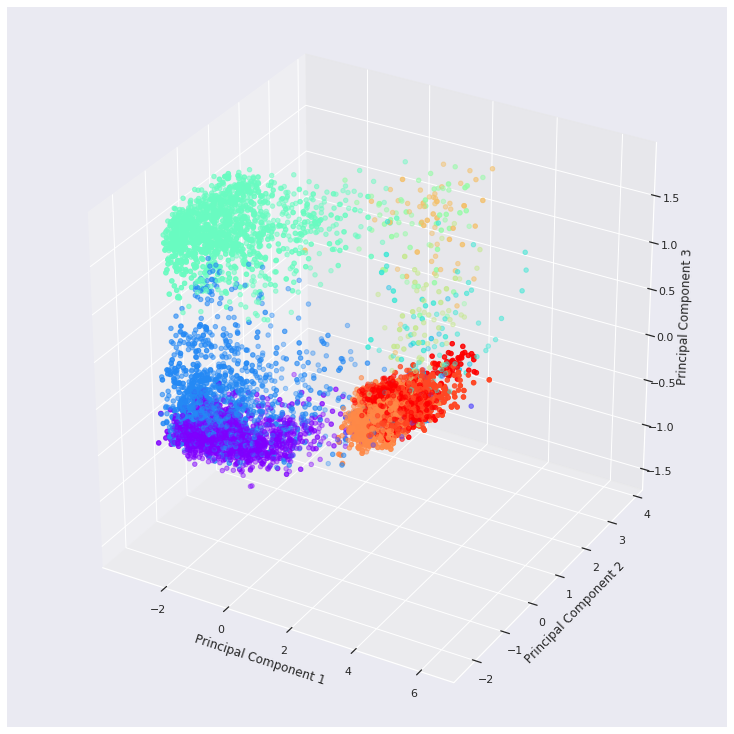

In [35]:
columns = {0: 'Principal Component 1'
          , 1: 'Principal Component 2'
          , 2: 'Principal Component 3'}
plot_3d(o_pca_train_df, 'activity', columns)

This looks like the previous plot. However, the variance in data is a little lesser, and 11 principal components can account for 80% of the variance in data now, as opposed to the 12 principal components earlier. Similarly, 37 principal components can account for 90% of the variance in data now, as opposed to the 38 principal components earlier.

We will now train a baseline model, logisitic regression, on the datasets we have obtained:
1. Original Preprocessed Data with all 531 features
2. Features whose variance ratio is lesser than 1
3. PCA (80% and 90% explained variance)
4. PCA (80% and 90% explained variance) after removing outliers using DBSCAN.

In [142]:
def evaluate_model(y_pred, y_true, labels, model_name):
    print("Accuracy: {}"
          .format(metrics.accuracy_score(y_true, y_pred)))
    precisions = metrics.precision_score(y_true
                                         , y_pred
                                         , average=None
                                         , labels=labels)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    _ = sns.barplot(x=labels, y=precisions, ax=ax1, color='blue')
    ax1.set_xlabel('Label')
    ax1.set_xticklabels(labels, rotation=90)
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision Scores - {}'.format(model_name))
    recalls = metrics.recall_score(y_true
                                   , y_pred
                                   , average=None
                                   , labels=labels)
    _ = sns.barplot(x=labels, y=recalls, ax=ax2, color='blue')
    ax2.set_xlabel('Label')
    ax2.set_xticklabels(labels, rotation=90)
    ax2.set_ylabel('Recall')
    ax2.set_title('Recall Scores - {}'.format(model_name))
    plt.tight_layout()
    confusion_matrix = metrics.confusion_matrix(y_true
                                                , y_pred
                                                , labels=unique_labels)
    confusion_matrix = pd.DataFrame(confusion_matrix
                                    , index=labels
                                    , columns=labels)
    plt.figure(figsize=(8, 8))
    _ = sns.heatmap(confusion_matrix)
    plt.title('Confusion Matrix - {}'.format(model_name))

In [56]:
unique_labels = non_numeric_data_df.activity.unique().tolist()

In [47]:
lr1 = LogisticRegression(multi_class='multinomial'
                        , solver='lbfgs'
                        , verbose=3)

In [79]:
lr1.fit(train_df.drop(['activity', 'split'], axis=1)
             , train_df['activity'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mihin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


Accuracy: 0.9813312733359083


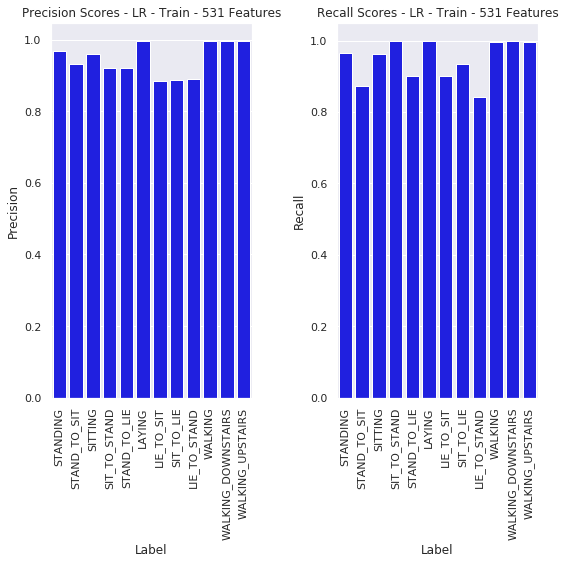

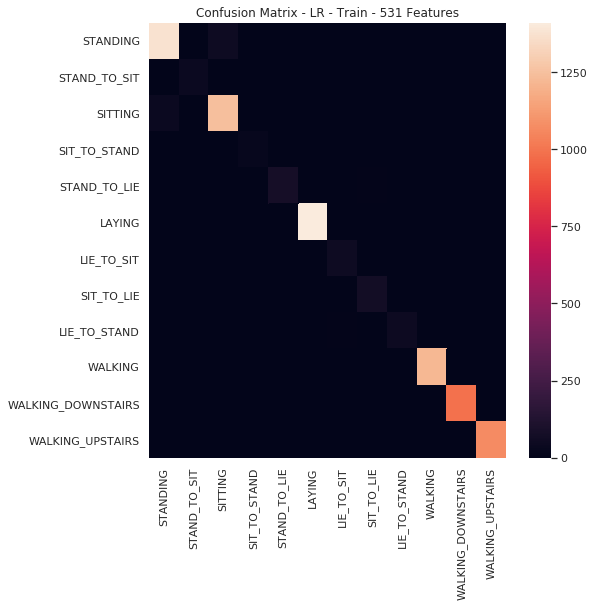

In [143]:
lr1_train_pred = lr1.predict(train_df.drop(['activity', 'split']
                                           , axis=1))
evaluate_model(lr1_train_pred, train_df['activity'], unique_labels, 'LR - Train - 531 Features')

Accuracy: 0.9367488931056294


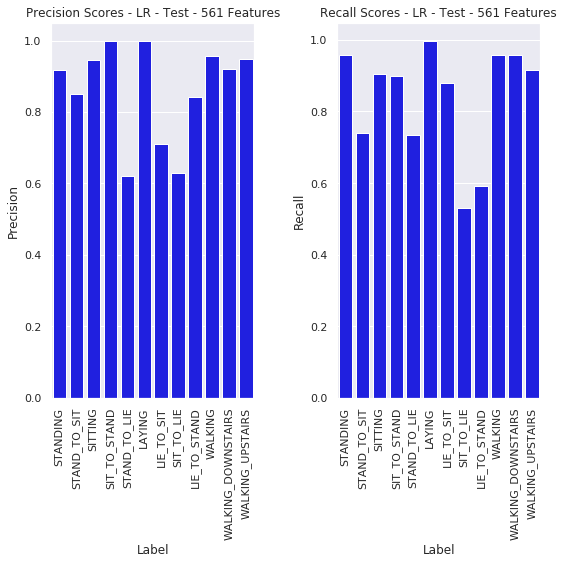

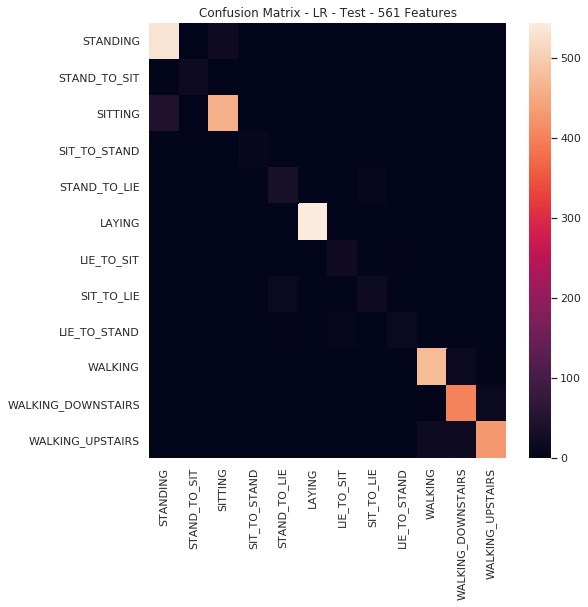

In [174]:
lr1_test_pred = lr1.predict(test_df.drop(['activity', 'split']
                                         , axis=1))
evaluate_model(lr1_test_pred, test_df['activity'], unique_labels, 'LR - Test - 561 Features')

In [173]:
print(metrics.classification_report(lr1_test_pred, test_df['activity']))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       544
        LIE_TO_SIT       0.88      0.71      0.79        31
      LIE_TO_STAND       0.59      0.84      0.70        19
           SITTING       0.91      0.95      0.93       486
        SIT_TO_LIE       0.53      0.63      0.58        27
      SIT_TO_STAND       0.90      1.00      0.95         9
          STANDING       0.96      0.92      0.94       580
      STAND_TO_LIE       0.73      0.62      0.67        58
      STAND_TO_SIT       0.74      0.85      0.79        20
           WALKING       0.96      0.96      0.96       497
WALKING_DOWNSTAIRS       0.96      0.92      0.94       437
  WALKING_UPSTAIRS       0.92      0.95      0.93       454

         micro avg       0.94      0.94      0.94      3162
         macro avg       0.84      0.86      0.85      3162
      weighted avg       0.94      0.94      0.94      3162



In [132]:
vr_features = variance_ratios_df[variance_ratios_df.variance_ratio > 1].feature.tolist()

In [137]:
lr2 = LogisticRegression(multi_class='multinomial'
                        , solver='lbfgs'
                        , verbose=3)
lr2.fit(train_df[vr_features], train_df['activity'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mihin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=3, warm_start=False)

Accuracy: 0.8170464786919016


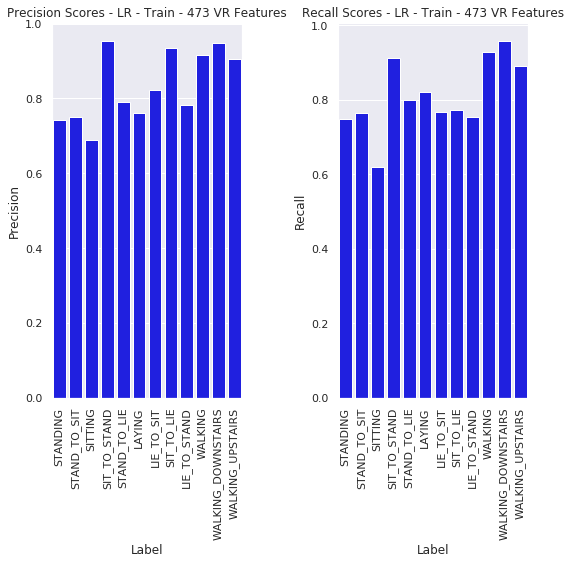

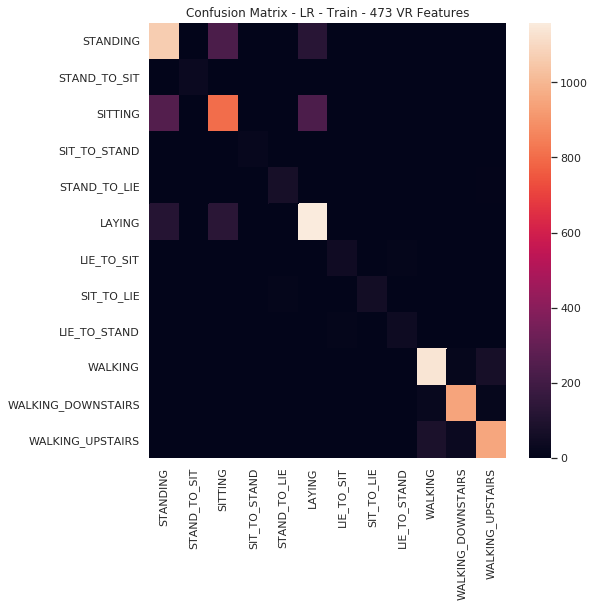

In [145]:
lr2_train_pred = lr2.predict(train_df[vr_features])
evaluate_model(lr2_train_pred, train_df.activity, unique_labels, 'LR - Train - 473 VR Features')

Accuracy: 0.7586970271979759


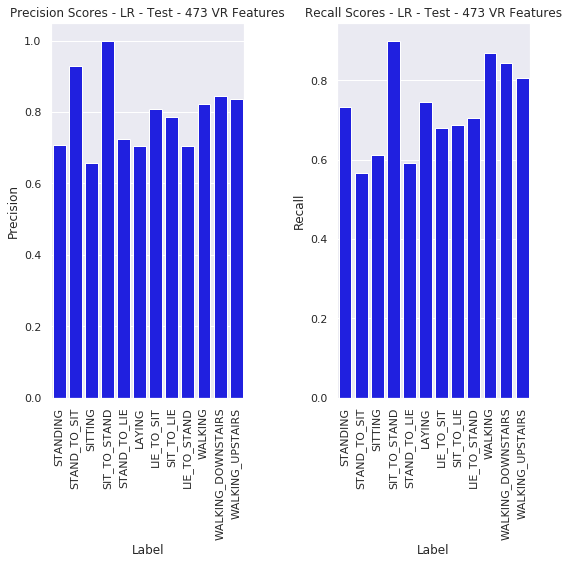

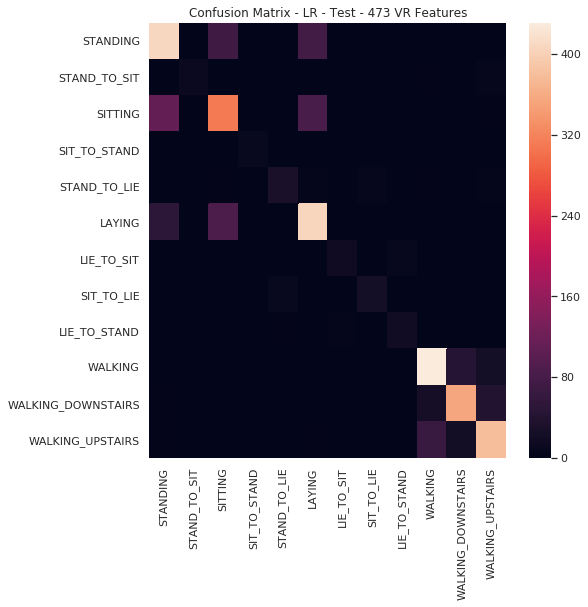

In [146]:
lr2_test_pred = lr2.predict(test_df[vr_features])
evaluate_model(lr2_test_pred, test_df.activity, unique_labels, 'LR - Test - 473 VR Features')

In [176]:
print(metrics.classification_report(lr2_test_pred, test_df.activity))

                    precision    recall  f1-score   support

            LAYING       0.74      0.70      0.72       576
        LIE_TO_SIT       0.68      0.81      0.74        21
      LIE_TO_STAND       0.70      0.70      0.70        27
           SITTING       0.61      0.66      0.63       474
        SIT_TO_LIE       0.69      0.79      0.73        28
      SIT_TO_STAND       0.90      1.00      0.95         9
          STANDING       0.73      0.71      0.72       576
      STAND_TO_LIE       0.59      0.72      0.65        40
      STAND_TO_SIT       0.57      0.93      0.70        14
           WALKING       0.87      0.82      0.85       524
WALKING_DOWNSTAIRS       0.84      0.84      0.84       419
  WALKING_UPSTAIRS       0.81      0.84      0.82       454

         micro avg       0.76      0.76      0.76      3162
         macro avg       0.73      0.79      0.76      3162
      weighted avg       0.76      0.76      0.76      3162



In [164]:
lr3 = LogisticRegression(multi_class='multinomial'
                        , solver='lbfgs'
                        , verbose=3)
lr3.fit(pca_train_df.drop(['id', 'activity', 'colors'], axis=1).values[:, :38]
        , pca_train_df.activity)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mihin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=3, warm_start=False)

Accuracy: 0.9459250675936655


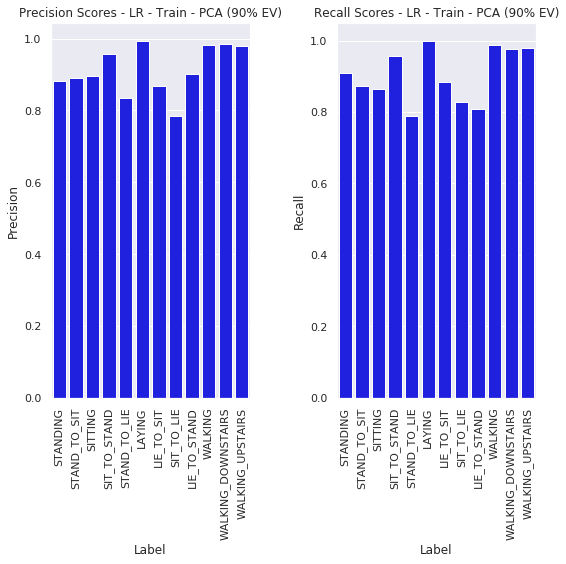

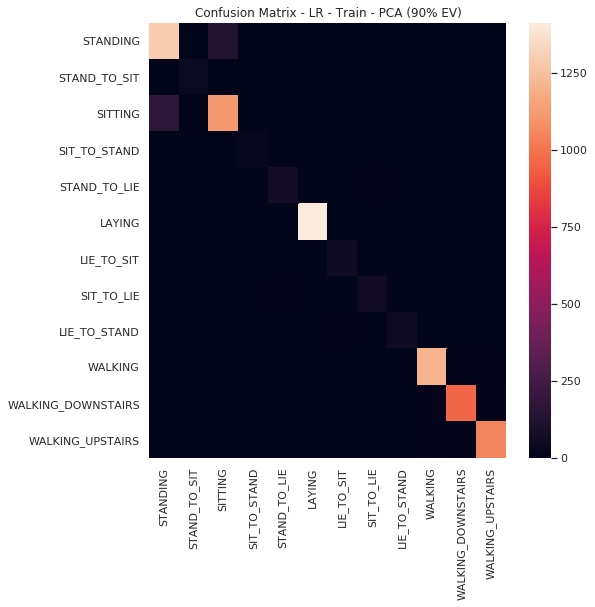

In [165]:
lr3_train_pred = lr3.predict(pca_train_df.drop(['id', 'activity', 'colors'], axis=1).values[:, :38])
evaluate_model(lr3_train_pred, pca_train_df.activity, unique_labels, 'LR - Train - PCA (90% EV)')

In [163]:
pca_test_df.drop(['id', 'activity'], axis=1).values[:, :12].shape

(3162, 12)

Accuracy: 0.09424414927261227


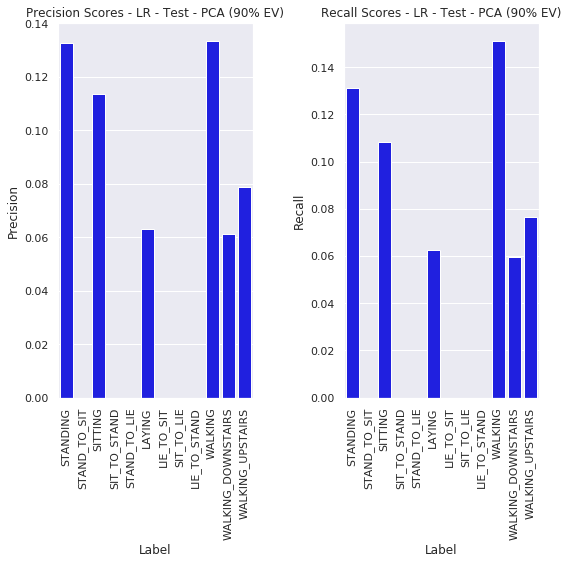

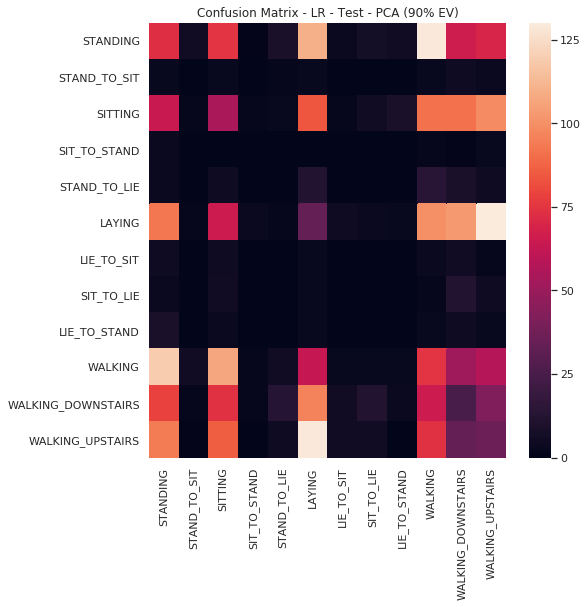

In [166]:
lr3_test_pred = lr3.predict(pca_test_df.drop(['id', 'activity'], axis=1).values[:, :38])
evaluate_model(lr3_test_pred, pca_test_df.activity, unique_labels, 'LR - Test - PCA (90% EV)')

In [177]:
print(metrics.classification_report(lr3_test_pred, pca_test_df.activity))

                    precision    recall  f1-score   support

            LAYING       0.06      0.06      0.06       540
        LIE_TO_SIT       0.00      0.00      0.00        26
      LIE_TO_STAND       0.00      0.00      0.00        25
           SITTING       0.11      0.11      0.11       485
        SIT_TO_LIE       0.00      0.00      0.00        38
      SIT_TO_STAND       0.00      0.00      0.00        11
          STANDING       0.13      0.13      0.13       551
      STAND_TO_LIE       0.00      0.00      0.00        40
      STAND_TO_SIT       0.00      0.00      0.00        19
           WALKING       0.15      0.13      0.14       562
WALKING_DOWNSTAIRS       0.06      0.06      0.06       408
  WALKING_UPSTAIRS       0.08      0.08      0.08       457

         micro avg       0.09      0.09      0.09      3162
         macro avg       0.05      0.05      0.05      3162
      weighted avg       0.10      0.09      0.09      3162



In [169]:
lr4 = LogisticRegression(multi_class='multinomial'
                        , solver='lbfgs'
                        , verbose=3)
lr4.fit(o_pca_train_df.drop(['id', 'activity', 'colors'], axis=1).values[:, :37]
        , o_pca_train_df.activity)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mihin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=3, warm_start=False)

Accuracy: 0.9427749953626414


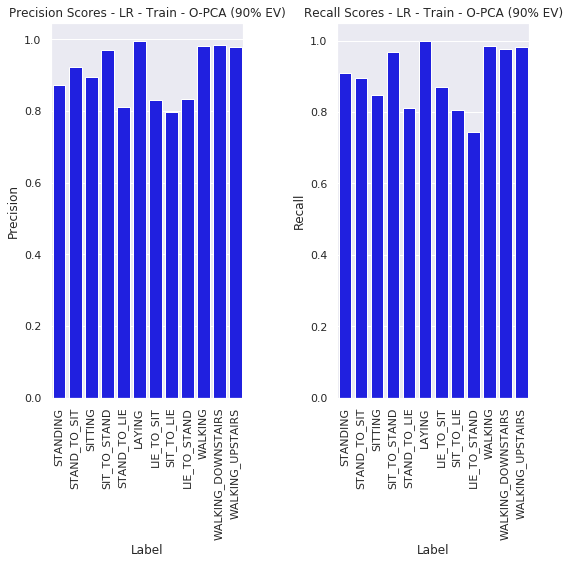

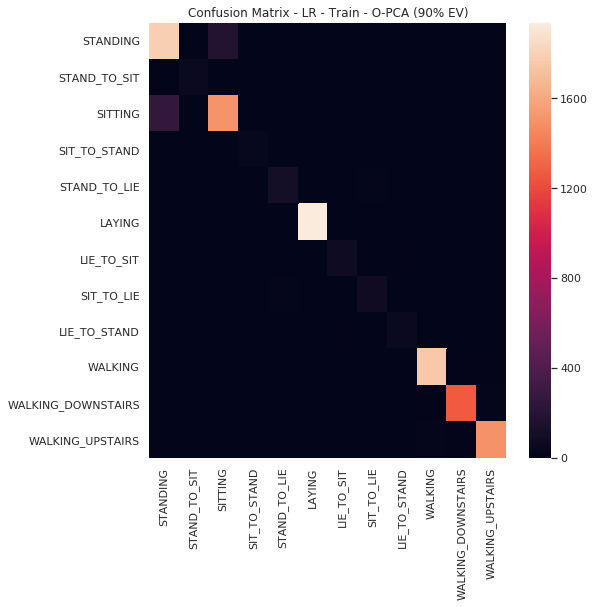

In [170]:
lr4_train_pred = lr4.predict(o_pca_train_df.drop(['id', 'activity', 'colors'], axis=1).values[:, :37])
evaluate_model(lr4_train_pred, o_pca_train_df.activity, unique_labels, 'LR - Train - O-PCA (90% EV)')

Accuracy: 0.09340659340659341


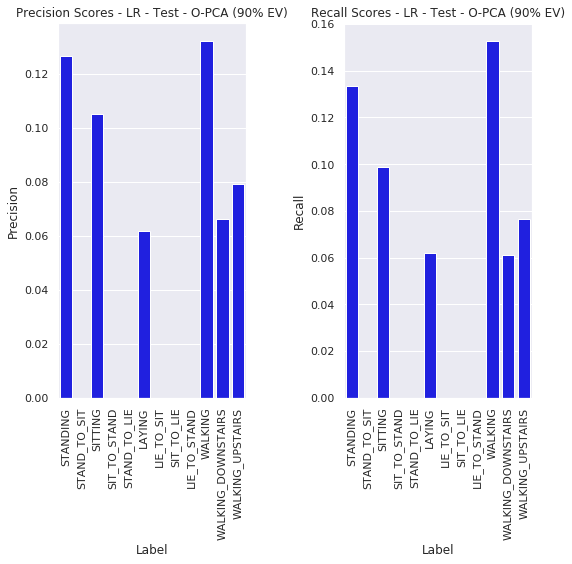

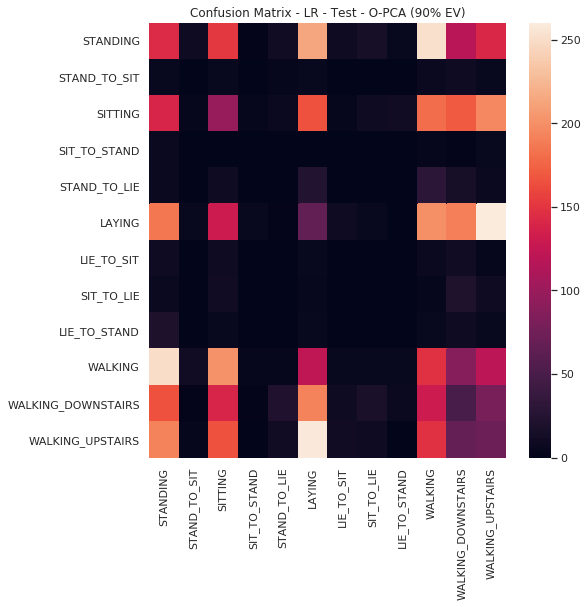

In [171]:
lr4_test_pred = lr4.predict(o_pca_test_df.drop(['id', 'activity'], axis=1).values[:, :37])
evaluate_model(lr4_test_pred, o_pca_test_df.activity, unique_labels, 'LR - Test - O-PCA (90% EV)')

In [178]:
print(metrics.classification_report(lr4_test_pred, o_pca_test_df.activity))

                    precision    recall  f1-score   support

            LAYING       0.06      0.06      0.06      1065
        LIE_TO_SIT       0.00      0.00      0.00        52
      LIE_TO_STAND       0.00      0.00      0.00        32
           SITTING       0.10      0.11      0.10       932
        SIT_TO_LIE       0.00      0.00      0.00        66
      SIT_TO_STAND       0.00      0.00      0.00        18
          STANDING       0.13      0.13      0.13      1138
      STAND_TO_LIE       0.00      0.00      0.00        64
      STAND_TO_SIT       0.00      0.00      0.00        38
           WALKING       0.15      0.13      0.14      1118
WALKING_DOWNSTAIRS       0.06      0.07      0.06       755
  WALKING_UPSTAIRS       0.08      0.08      0.08       910

         micro avg       0.09      0.09      0.09      6188
         macro avg       0.05      0.05      0.05      6188
      weighted avg       0.10      0.09      0.09      6188

